# Day 2 PM: Preparing data for analysis with `tidyr`

Visualization, modeling and inference in R is simplest when the data is collected into a single "tidy" `data.frame`. What constitutes a tidy `data.frame` depends somewhat on the context, but at a minimum it requires that each can be interpreted as an **observation**, each column as a **variable**,  and each cell contains a **value**.

The original data set may vary from this ideal tidy format in several ways, and the `tidyr` package provides tools for us to convert data from messy to tidy. In particular, we show several common issues that we need to address to make data tidy. Here, we focus on three main verbs for tidying data - `gather`, `spread` and `separate`. We also briefly discuss what to do when the data is originally distributed over several files.

In [4]:
suppressPackageStartupMessages(library(tidyverse))

Warning message:
“Installed Rcpp (0.12.12) different from Rcpp used to build dplyr (0.12.11).
Please reinstall dplyr to avoid random crashes or undefined behavior.”Warning message:
“package ‘dplyr’ was built under R version 3.4.1”

## Splitting columns with `separate`

One common issue is that the values in a single column are actually a combination of many variables. For example, there may be a "description" field that combines site ID,, patient ID and date. Tidy data requires that each column represents a single variable, and we need to `separate` the variables.

### Make up a data set for illustration

In [4]:
sites <- paste("site", 1:10, sep="")
sites

[1] "site1"  "site2"  "site3"  "site4"  "site5"  "site6"  "site7"  "site8" 
 [9] "site9"  "site10"

In [5]:
subjects <- sample.int(100, 10)
subjects

[1] 64  7 96 28 89 69 29 65 51 18

In [6]:
dates <- sample(seq(as.Date('2016/01/01'), 
                    as.Date('2017/01/01'), by="day"), 10)
dates

[1] "2016-05-25" "2016-07-23" "2016-08-04" "2016-07-04" "2016-12-06"
 [6] "2016-10-29" "2016-08-13" "2016-09-17" "2016-11-16" "2016-04-23"

In [7]:
df <- data.frame(description=paste(sites, subjects, dates, sep=":"),
                 score=rnorm(10))

In [8]:
head(df)

description         score     
1 site1:64:2016-05-25 -1.3108151
2 site2:7:2016-07-23   1.6269679
3 site3:96:2016-08-04  0.5706658
4 site4:28:2016-07-04 -1.7594424
5 site5:89:2016-12-06  0.9366193
6 site6:69:2016-10-29  0.5264268

### Using `separate`

In [9]:
df %>% separate(col=description, into=c("site", "pid", "date"), sep=":") %>% head

site  pid date       score     
1 site1 64  2016-05-25 -1.3108151
2 site2 7   2016-07-23  1.6269679
3 site3 96  2016-08-04  0.5706658
4 site4 28  2016-07-04 -1.7594424
5 site5 89  2016-12-06  0.9366193
6 site6 69  2016-10-29  0.5264268

### When a single separator is not enough

In [10]:
df.1 <- data.frame(description=paste(sites, subjects, dates, sep="-"),
                   score=rnorm(10))

In [11]:
head(df.1)

description         score     
1 site1-64-2016-05-25  0.9018461
2 site2-7-2016-07-23   1.8470596
3 site3-96-2016-08-04  0.1700874
4 site4-28-2016-07-04 -0.7663310
5 site5-89-2016-12-06 -1.0308395
6 site6-69-2016-10-29  1.2056017

### Using `extract` (advanced)

The verb `extract` is like separate, but instead of using a separator, it uses a **regular expression** to split strings. A crash course in regular expressions:

- `abc` matches the characters 'abc'
- `-` matches the character '-'
- `[abc]` matches `a` or `b` or `c`
- `[a-z]` matches any lower case letter
- `[0-9]` matches any digit
- `.` matches any single character
- `\\d` matches any single digit
- `+` matches one or more of the preceding character set
- `*` matches zero or more of the preceding character set
- `{m, n}` matches between m and n copies of the preceding character set
- `()` indicates a capture group - the separated values desired

In [12]:
df.1 %>% extract(col=description,  into=c("site", "pid", "date"), regex="site([0-9]+)-([0-9]+)-(.*)") %>% head

site pid date       score     
1 1    64  2016-05-25  0.9018461
2 2    7   2016-07-23  1.8470596
3 3    96  2016-08-04  0.1700874
4 4    28  2016-07-04 -0.7663310
5 5    89  2016-12-06 -1.0308395
6 6    69  2016-10-29  1.2056017

### Separate rows

Less commonly, a single row contains multiple observations needs to be separated into multiple rows using `separate_rows` or `extract_rows`.

In [13]:
df.2 <- data.frame(pid=1:10, scores=replicate(10, paste(sample(1:10000, 3), collapse=",")))

In [14]:
head(df.2)

pid scores        
1 1   5631,9112,2114
2 2   720,6652,4332 
3 3   9810,243,853  
4 4   8522,7479,9176
5 5   8715,7581,3025
6 6   4658,6293,9580

In [15]:
df.2 %>% separate_rows(col=scores, sep=",") %>% head

pid scores
1 1   5631  
2 1   9112  
3 1   2114  
4 2   720   
5 2   6652  
6 2   4332

## From columns to key-value pairs with `gather`

Sometimes a single variable is spread out over multiple columns. For example, we may wish to consider the `Sepal.Length`, `Sepal.Width`, `Petal.Length` and `Petal.Width` as variants of a single variable `measure`. The verb to use is `gather` which transforms a "wide" `data.frame` into a "tall" one.

For example, suppose we want `ggplot2` to plot each measurement in a separate panel, colored by `Species`. 

In [16]:
head(iris, n=3)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1 5.1          3.5         1.4          0.2         setosa 
2 4.9          3.0         1.4          0.2         setosa 
3 4.7          3.2         1.3          0.2         setosa

In [17]:
iris %>% gather(key=measure, value = value, 1:4) %>% head(n=3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7

### Alternative ways of specifying columns to gather

In [18]:
iris %>% gather(measure, value, 1:4) %>% head(n=3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7

In [19]:
iris %>% gather(measure, value, c(Sepal.Length, Sepal.Width, Petal.Length, Petal.Width)) %>% head(n=3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7

In [20]:
iris %>% gather(measure, value, Sepal.Length, Sepal.Width, Petal.Length, Petal.Width) %>% head(n=3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7

In [21]:
iris %>% gather(measure, value, -Species) %>% head(n=3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7

In [22]:
iris %>% gather(measure, value, -5) %>% head(n=3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7

### Use of `gather` for plotting

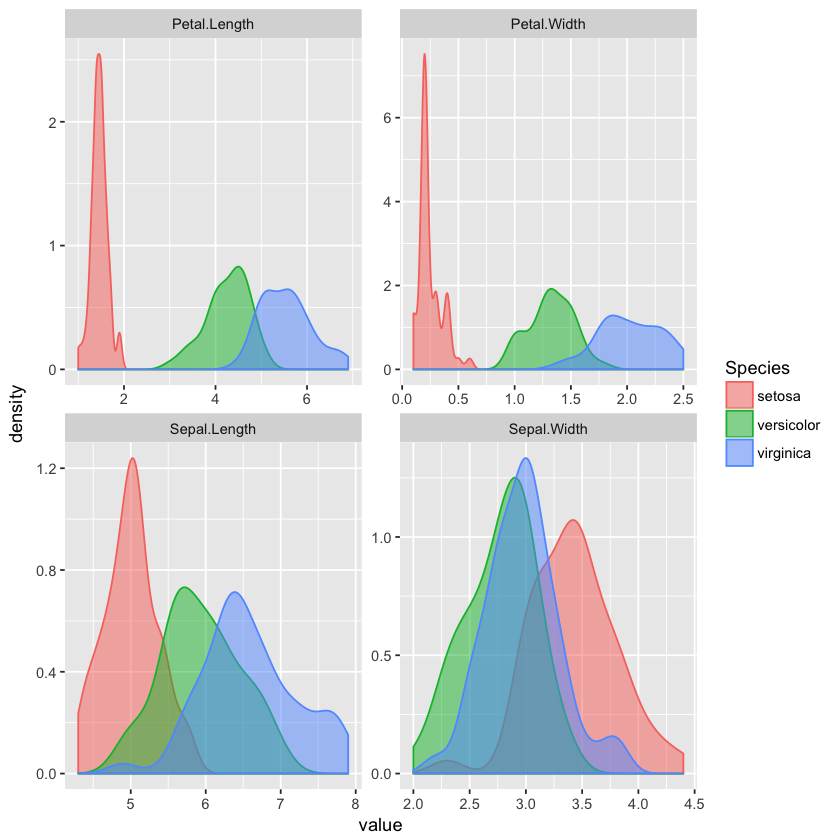

In [23]:
df.3 <- iris %>% gather(measure, value, -Species)
ggplot(df.3, aes(x=value, color=Species, fill=Species)) +
geom_density(alpha=0.5) +
facet_wrap(~ measure, scales = "free")

## From key-value pairs to columns with `spread`

The verb `spread` is the reverse of `gather` - it makes a "tall" `data.frame` into a "wide" one. However, it requires that each row have a unique identifier to do so. If we just try to apply `spread` to the tall version of `iris`, it will fail because there are 50 of each Species. We therefore need to generate a new column to make each row have a unique identifier.

In [24]:
head(df.3)

Species measure      value
1 setosa  Sepal.Length 5.1  
2 setosa  Sepal.Length 4.9  
3 setosa  Sepal.Length 4.7  
4 setosa  Sepal.Length 4.6  
5 setosa  Sepal.Length 5.0  
6 setosa  Sepal.Length 5.4

In [25]:
df.3$n <- rep(1:50, 12)

In [26]:
iris.1 <- df.3 %>% spread(measure, value)
head(iris.1)

Species n Petal.Length Petal.Width Sepal.Length Sepal.Width
1 setosa  1 1.4          0.2         5.1          3.5        
2 setosa  2 1.4          0.2         4.9          3.0        
3 setosa  3 1.3          0.2         4.7          3.2        
4 setosa  4 1.5          0.2         4.6          3.1        
5 setosa  5 1.4          0.2         5.0          3.6        
6 setosa  6 1.7          0.4         5.4          3.9

#### We can drop the column n now

In [27]:
iris.2 <- iris.1[, -2]
head(iris.2)

Species Petal.Length Petal.Width Sepal.Length Sepal.Width
1 setosa  1.4          0.2         5.1          3.5        
2 setosa  1.4          0.2         4.9          3.0        
3 setosa  1.3          0.2         4.7          3.2        
4 setosa  1.5          0.2         4.6          3.1        
5 setosa  1.4          0.2         5.0          3.6        
6 setosa  1.7          0.4         5.4          3.9

#### How to do all this in a single fluent command using pipes (explained in next session)

In [28]:
df.3 <- df.3[,-4] # remove n to restore oroignal tall format

In [29]:
df.3 %>% 
mutate(n=rep(1:50,12)) %>% 
spread(measure, value) %>% 
select(-n) %>% 
head

Species Petal.Length Petal.Width Sepal.Length Sepal.Width
1 setosa  1.4          0.2         5.1          3.5        
2 setosa  1.4          0.2         4.9          3.0        
3 setosa  1.3          0.2         4.7          3.2        
4 setosa  1.5          0.2         4.6          3.1        
5 setosa  1.4          0.2         5.0          3.6        
6 setosa  1.7          0.4         5.4          3.9

## When variables are stored in both rows and columns (advanced)

In the toy example below, we measure peak and trough levels of something (blood glucose level, viral titers etc) recorded between visits. We convert this into a tidy data frame in two steps:

1. Use `tidyr::gather` to create a new column variable `visit`
2. Use `tidyr::spread` to create `peak` and `trough` column variables from each row of `measure`

In [2]:
subject <- c("Ann", "Ann", "Bob", "Bob", "Charlie", "Charlie")
measure <- c("peak", "trough", "peak", "trough", "peak", "trough")
visit1 <- c(250, 125, 1000, 750, 1500, 250)
visit2 <- c(500, 125, 900, 650, 1550, 500)
df.4 <- data.frame(subject, measure, visit1, visit2)
df.4

subject measure visit1 visit2
1 Ann     peak     250    500  
2 Ann     trough   125    125  
3 Bob     peak    1000    900  
4 Bob     trough   750    650  
5 Charlie peak    1500   1550  
6 Charlie trough   250    500

### First gather the visit values ioto a single column

In [7]:
df.5 <- df.4 %>% gather(visit, value, visit1, visit2)
df.5

subject measure visit  value
1  Ann     peak    visit1  250 
2  Ann     trough  visit1  125 
3  Bob     peak    visit1 1000 
4  Bob     trough  visit1  750 
5  Charlie peak    visit1 1500 
6  Charlie trough  visit1  250 
7  Ann     peak    visit2  500 
8  Ann     trough  visit2  125 
9  Bob     peak    visit2  900 
10 Bob     trough  visit2  650 
11 Charlie peak    visit2 1550 
12 Charlie trough  visit2  500

### Then spread the peak and trough measurements

In [8]:
df.5 %>% spread(measure, value)

subject visit  peak trough
1 Ann     visit1  250 125   
2 Ann     visit2  500 125   
3 Bob     visit1 1000 750   
4 Bob     visit2  900 650   
5 Charlie visit1 1500 250   
6 Charlie visit2 1550 500

### In one fluent command

In [10]:
df.4 %>%
gather(visit, value, visit1, visit2) %>%
spread(measure, value)

subject visit  peak trough
1 Ann     visit1  250 125   
2 Ann     visit2  500 125   
3 Bob     visit1 1000 750   
4 Bob     visit2  900 650   
5 Charlie visit1 1500 250   
6 Charlie visit2 1550 500

## Working with missing data

Sometimes cells contain missing values. Here we show the simplest way to deal with this common scenario.  The approach shown is not always appropriate - consult a statistician if in doubt.

In [30]:
iris.missing <- iris
iris.missing[2,3] <- NA
iris.missing[4:6, 1] <- NA

In [31]:
head(iris.missing)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1 5.1          3.5         1.4          0.2         setosa 
2 4.9          3.0          NA          0.2         setosa 
3 4.7          3.2         1.3          0.2         setosa 
4  NA          3.1         1.5          0.2         setosa 
5  NA          3.6         1.4          0.2         setosa 
6  NA          3.9         1.7          0.4         setosa

### Drop any row with missing data

This is known as complete case analysis, and is appropriate when you have abundant observations and the missing values are believed to be missing at random.

In [32]:
iris.missing %>% drop_na %>% head

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1  5.1          3.5         1.4          0.2         setosa 
3  4.7          3.2         1.3          0.2         setosa 
7  4.6          3.4         1.4          0.3         setosa 
8  5.0          3.4         1.5          0.2         setosa 
9  4.4          2.9         1.4          0.2         setosa 
10 4.9          3.1         1.5          0.1         setosa

## Combining data with `join` (part of `dplyr`)

Sometimes data is distributed over many files. In the simplest case, each data set has exactly the same format as the others, and we just need to append additional rows. At other times, each data set contains some different variable (e.g. merging clinical and assay data) and we need to match rows according to some unique row identifier.

### When each data.frame is similar

In [33]:
levels(iris$Species)

[1] "setosa"     "versicolor" "virginica"

In [34]:
setosa <- iris %>% filter(Species=="setosa")
versicolor <- iris %>% filter(Species=="versicolor")
virginica <- iris %>% filter(Species=="virginica")

In [35]:
dim(setosa)

[1] 50  5

In [36]:
head(setosa, 3)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species
1 5.1          3.5         1.4          0.2         setosa 
2 4.9          3.0         1.4          0.2         setosa 
3 4.7          3.2         1.3          0.2         setosa

In [37]:
dim(versicolor)

[1] 50  5

In [38]:
head(versicolor, 3)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species   
1 7.0          3.2         4.7          1.4         versicolor
2 6.4          3.2         4.5          1.5         versicolor
3 6.9          3.1         4.9          1.5         versicolor

In [39]:
dim(virginica)

[1] 50  5

In [40]:
head(virginica, 3)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species  
1 6.3          3.3         6.0          2.5         virginica
2 5.8          2.7         5.1          1.9         virginica
3 7.1          3.0         5.9          2.1         virginica

In [41]:
iris.combined <- bind_rows(setosa, versicolor, virginica)

In [42]:
dim(iris.combined)

[1] 150   5

In [43]:
iris.combined %>% sample_n(10)

Sepal.Length Sepal.Width Petal.Length Petal.Width Species   
43  4.4          3.2         1.3          0.2         setosa    
129 6.4          2.8         5.6          2.1         virginica 
26  5.0          3.0         1.6          0.2         setosa    
15  5.8          4.0         1.2          0.2         setosa    
3   4.7          3.2         1.3          0.2         setosa    
7   4.6          3.4         1.4          0.3         setosa    
145 6.7          3.3         5.7          2.5         virginica 
131 7.4          2.8         6.1          1.9         virginica 
85  5.4          3.0         4.5          1.5         versicolor
28  5.2          3.5         1.5          0.2         setosa

### When the rows are perfectly aligned

In [13]:
lengths <- iris %>% select(Species, Sepal.Length, Petal.Length)
head(lengths, 3)

Species Sepal.Length Petal.Length
1 setosa  5.1          1.4         
2 setosa  4.9          1.4         
3 setosa  4.7          1.3

In [14]:
widths <- iris %>% select(Sepal.Width, Petal.Width)
head(widths, 3)

Sepal.Width Petal.Width
1 3.5         0.2        
2 3.0         0.2        
3 3.2         0.2

In [16]:
lengths %>% bind_cols(widths) %>% head

Species Sepal.Length Petal.Length Sepal.Width Petal.Width
1 setosa  5.1          1.4          3.5         0.2        
2 setosa  4.9          1.4          3.0         0.2        
3 setosa  4.7          1.3          3.2         0.2        
4 setosa  4.6          1.5          3.1         0.2        
5 setosa  5.0          1.4          3.6         0.2        
6 setosa  5.4          1.7          3.9         0.4

### When data frames are different

In [44]:
df.clin <- data.frame(site.id=c('A', 'A', 'A', 'B', 'B', 'B'), 
                      pt.id=c(100, 101, 102, 100, 102, 105), 
                      age=c(38, 35, 43, 50, 62, 50))
df.clin

site.id pt.id age
1 A       100   38 
2 A       101   35 
3 A       102   43 
4 B       100   50 
5 B       102   62 
6 B       105   50

In [45]:
df.lab <- data.frame(site.id=c('B', 'B', 'B', 'A', 'A', 'A'),
                     pt.id=c(103, 100, 105, 100, 101, 102),
                     values=sample(100:1000, 6))
df.lab

site.id pt.id values
1 B       103   872   
2 B       100   623   
3 B       105   307   
4 A       100   325   
5 A       101   651   
6 A       102   255

#### Keep only elements in common

In [46]:
df.clin %>% inner_join(df.lab, by = c("site.id", "pt.id"))

site.id pt.id age values
1 A       100   38  325   
2 A       101   35  651   
3 A       102   43  255   
4 B       100   50  623   
5 B       105   50  307

#### Keep all rows in df.clin

In [47]:
df.clin %>% left_join(df.lab, by = c("site.id", "pt.id"))

site.id pt.id age values
1 A       100   38  325   
2 A       101   35  651   
3 A       102   43  255   
4 B       100   50  623   
5 B       102   62   NA   
6 B       105   50  307

#### Keep all rows in df.lab

In [48]:
df.clin %>% right_join(df.lab, by = c("site.id", "pt.id"))

site.id pt.id age values
1 B       103   NA  872   
2 B       100   50  623   
3 B       105   50  307   
4 A       100   38  325   
5 A       101   35  651   
6 A       102   43  255

#### Keep all rows in df.clin or df.lab

In [49]:
df.clin %>% full_join(df.lab, by = c("site.id", "pt.id"))

site.id pt.id age values
1 A       100   38  325   
2 A       101   35  651   
3 A       102   43  255   
4 B       100   50  623   
5 B       102   62   NA   
6 B       105   50  307   
7 B       103   NA  872

### When identifier columns have different names

In [50]:
df.lab.1 <- data.frame(site=c('B', 'B', 'B', 'A', 'A', 'A'),
                     pid=c(103, 100, 105, 100, 101, 102),
                     values=sample(100:1000, 6))
df.lab.1

site pid values
1 B    103 625   
2 B    100 517   
3 B    105 736   
4 A    100 739   
5 A    101 165   
6 A    102 944

#### Keep only elements in common

In [51]:
df.clin %>% inner_join(df.lab.1, by = c("site.id"="site", "pt.id"="pid"))

site.id pt.id age values
1 A       100   38  739   
2 A       101   35  165   
3 A       102   43  944   
4 B       100   50  517   
5 B       105   50  736

### When identifiers are in the row.names (advanced)

In [52]:
df.lab.2 <- data.frame(values=sample(100:1000, 6))
rownames(df.lab.2) <- paste(c('B', 'B', 'B', 'A', 'A', 'A'),
                           c(103, 100, 105, 100, 101, 102), sep="-")
df.lab.2

values
B-103 963   
B-100 556   
B-105 620   
A-100 335   
A-101 886   
A-102 115

In [53]:
df.lab.2 %>% 
    rownames_to_column %>%
  separate(rowname, into=c("site.id", "pt.id"), sep="-")

site.id pt.id values
1 B       103   963   
2 B       100   556   
3 B       105   620   
4 A       100   335   
5 A       101   886   
6 A       102   115

In [54]:
df.clin %>% inner_join(
    # create new data.frame with matching identifier columns
    df.lab.2 %>% 
    rownames_to_column %>% 
    separate(rowname, into=c("site.id", "pt.id"), sep="-") %>%
    mutate(site.id=as.factor(site.id), pt.id=as.numeric(pt.id)),
    # specify columns to join on
    by=c("site.id", "pt.id")    
)

site.id pt.id age values
1 A       100   38  335   
2 A       101   35  886   
3 A       102   43  115   
4 B       100   50  556   
5 B       105   50  620